# Praca domowa 4
## XAI
## Paulina Jaszczuk

### Import pakietów 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb

from tqdm.notebook import tqdm

from math import sqrt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

### Wczytanie danych i poglądowe informacje

Zajemiemy się problemem klasyfikacji dla danych dotyczących zadowolenia klientów linii lotniczych.

In [118]:
aps_train = pd.read_csv("C:\\Users\\pauli\\Downloads\\wb_hw2_data\\airline_passenger_satisfaction\\train.csv")
aps_test = pd.read_csv("C:\\Users\\pauli\\Downloads\\wb_hw2_data\\airline_passenger_satisfaction\\test.csv")

In [119]:
aps_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
aps_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

### Inżynieria danych

In [5]:
# Zmienne 'Gender', 'Customer Type', 'Tyoe of Travel', 'satisfaction' mają po 2 wartości - kodujemy je binarnie
aps_train['Gender'] = (aps_train['Gender'] == 'Female')*1
aps_train['Customer Type'] = (aps_train['Customer Type'] == 'Loyal Customer')*1
aps_train['Type of Travel'] = (aps_train['Type of Travel'] == 'Personal Travel')*1
aps_train['satisfaction'] = (aps_train['satisfaction'] == 'satisfied')*1

# 'Class' przyjmuje 3 wartości - robimy one hot encoding i wyrzucamy jedną kolumnę, żeby uniknąć liniowości
encoded_train = pd.get_dummies(aps_train[["Class"]].astype(str))
encoded_train = encoded_train.drop(["Class_Eco Plus"], axis = 1)
aps_train = pd.concat([aps_train, encoded_train], axis = 1)

aps_train = aps_train.drop(columns=["Unnamed: 0","Class"],axis=1)#dropping


aps_test['Gender'] = (aps_test['Gender'] == 'Female')*1
aps_test['Customer Type'] = (aps_test['Customer Type'] == 'Loyal Customer')*1
aps_test['Type of Travel'] = (aps_test['Type of Travel'] == 'Personal Travel')*1
aps_test['satisfaction'] = (aps_test['satisfaction'] == 'satisfied')*1

encoded_test = pd.get_dummies(aps_test[["Class"]].astype(str))
encoded_test = encoded_test.drop(["Class_Eco Plus"], axis = 1)
aps_test = pd.concat([aps_test, encoded_test], axis = 1)

aps_test = aps_test.drop(columns=["Unnamed: 0","Class"],axis=1)#dropping

In [6]:
# Usuwamy wiersze z brakami danych
aps_train.drop(aps_train[aps_train["Arrival Delay in Minutes"].isnull()].index, axis=0, inplace=True)
aps_test.drop(aps_test[aps_test["Arrival Delay in Minutes"].isnull()].index, axis=0, inplace=True)

In [7]:
# Zbiór treningowy dzielimy na treningowy i walidacyjny w proporcjach 9:1
y_aps = aps_train['satisfaction']
X_aps = aps_train.drop(['satisfaction'], axis = 1)
X_train_aps, X_val_aps, y_train_aps, y_val_aps = train_test_split(X_aps, y_aps, random_state=420, test_size=0.1)

y_test_aps = aps_test['satisfaction']
X_test_aps = aps_test.drop(['satisfaction'], axis = 1)

In [8]:
print("X Train : ", X_train_aps.shape)
print("X Val  : ", X_val_aps.shape)
print("X Test  : ", X_test_aps.shape)
print("Y Train : ", y_train_aps.shape)
print("Y Val : ", y_val_aps.shape)
print("Y Test  : ", y_test_aps.shape)

X Train :  (93234, 24)
X Val  :  (10360, 24)
X Test  :  (25893, 24)
Y Train :  (93234,)
Y Val :  (10360,)
Y Test  :  (25893,)


### Modelowanie

In [9]:
# Random Forest Classifier Model
rfc=RandomForestClassifier()

rfc.fit(X_train_aps,y_train_aps)

print("accuracy score train : ", rfc.score(X_train_aps,y_train_aps))
print("accuracy score val : ", rfc.score(X_val_aps,y_val_aps))

y_predRFC=rfc.predict(X_val_aps)
y_predRFC_proba = rfc.predict_proba(X_val_aps)

print("r2 score val : " ,r2_score(y_val_aps,y_predRFC))
print("F1 score val : " ,f1_score(y_val_aps,y_predRFC))
print("RMSE score val : " ,sqrt(MSE(y_val_aps, y_predRFC)))
print("roc auc score val : " ,roc_auc_score(y_val_aps,y_predRFC))

accuracy score train :  1.0
accuracy score val :  0.9618725868725869
r2 score val :  0.845193198109467
F1 score val :  0.9559888579387187
RMSE score val :  0.19526242118598533
roc auc score val :  0.9598302602923428


### XAI

#### DALEX

Do XAI użyję pakietu DALEX. Dostarcza on narzędzi do analizy zarówno lokalnej na poziomie instancji jak i globalnej.

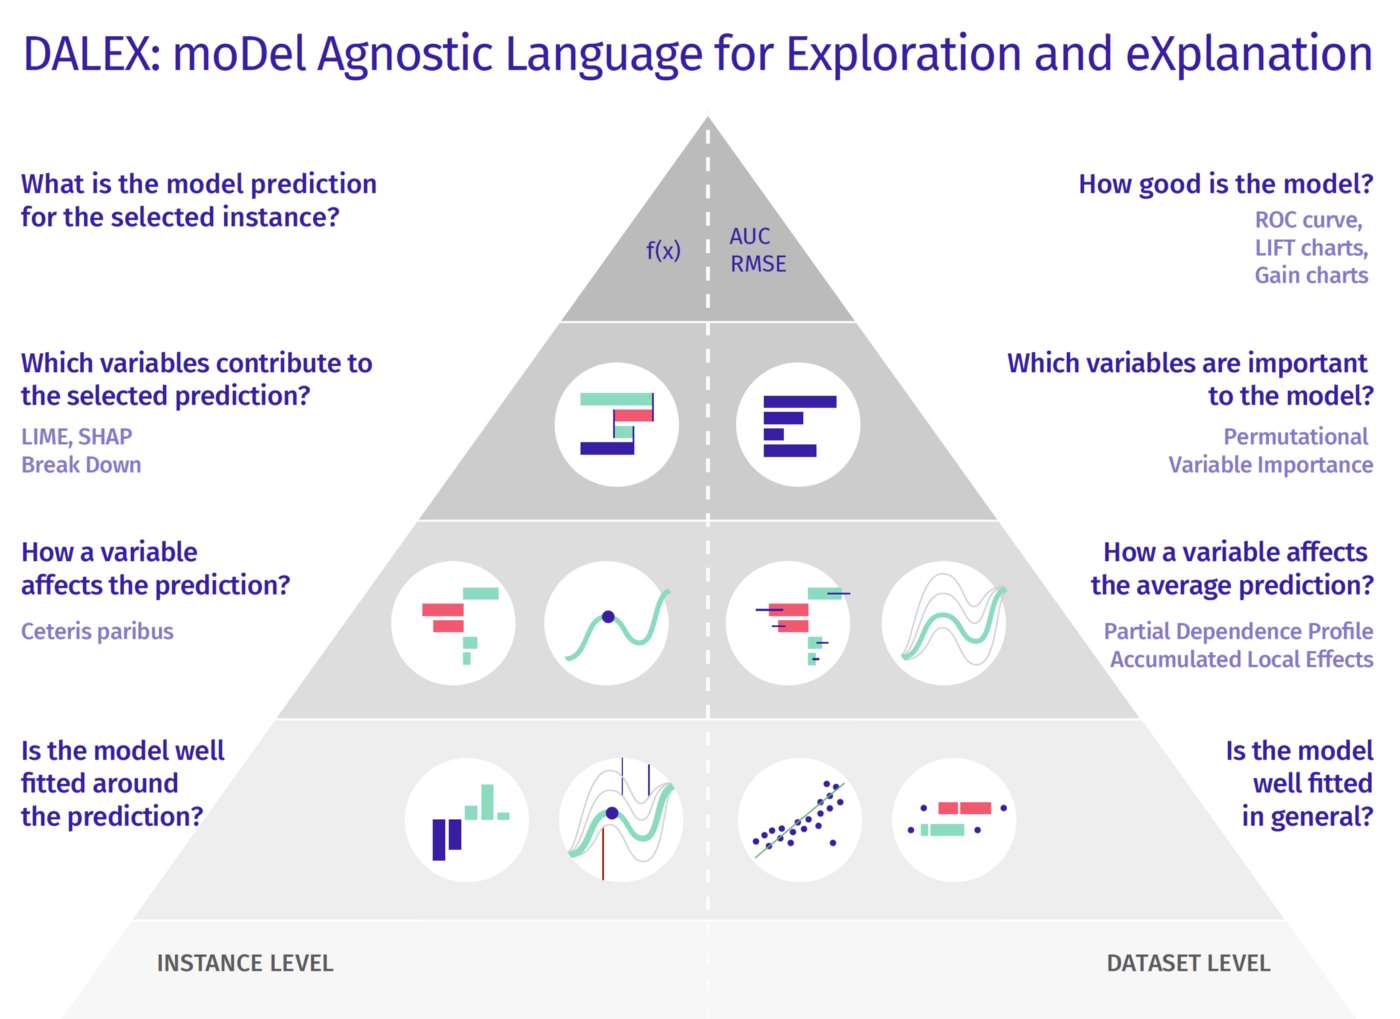

In [141]:
import dalex as dx
import lime

In [11]:
explainer = dx.Explainer(rfc,X_aps,y_aps) # create explainer from Dalex

Preparation of a new explainer is initiated

  -> data              : 103594 rows 24 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 103594 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001BFB3FD29D8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.434, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.96, mean = -0.000423, max = 0.99
  -> model_info        : package sklearn

A new explainer has been created!


#### Analiza lokalna

W analizie lokalnej zajmiemy się wyjaśnianiem predykcji obserwacji nr 102 i 0 ze zbioru walidacyjnego.

##### Pasażer nr 102

Pasażerka nr 102 jest 26 letnią kobietą oznaczoną jako "klient nielojalny". Lot był podróżą biznesową na dystansie 432km. Wylot i przylot nie był opóźniony. Kobieta leciała klasą biznes. Poniżej przedstawiono poziom jej satysfakcji z różnych aspektów lotu w skali od 0 do 5 (0 - nie dotyczny, 1 - niezadowolona, 5 - bardzo zadowolona).

In [126]:
X_val_aps.iloc[102, 6:20]

Inflight wifi service                4.0
Departure/Arrival time convenient    4.0
Ease of Online booking               4.0
Gate location                        3.0
Food and drink                       2.0
Online boarding                      4.0
Seat comfort                         2.0
Inflight entertainment               2.0
On-board service                     4.0
Leg room service                     4.0
Baggage handling                     5.0
Checkin service                      5.0
Inflight service                     5.0
Cleanliness                          2.0
Name: 21230, dtype: float64

In [129]:
#przewidziana wartość satysfakcji z lotu
y_predRFC[102]

1

Jak widać nasz model przewidział, że klientka była zadowolona z lotu.

In [76]:
#przewidziane prawdopodobieństwo satysfakcji z lotu
y_predRFC_proba[102]

array([0.39, 0.61])

Nie był jednak pewien swojego wyboru - prowdopodobieństwo wyznaczył na 61%.

In [117]:
#rzeczywista wartość satysfakcji z lotu
y_val_aps_i = y_val_aps.reset_index() # Resets the index, makes factor a column
y_val_aps_i.iloc[102, :]

index           21230
satisfaction        1
Name: 102, dtype: int64

W rzeczywistości klientka również była zadowolona.

In [120]:
# breakdown plot
explainer.predict_parts(X_val_aps.iloc[102, :]).plot(max_vars=15)

Pierwsze co rzuca się w oczy to fakt, że najbardziej zaniżyła predykcję zmienna `Customer Type`. Być może model nauczył się, że klienci, którzy latają również innymi liniami (oznaczeni jako `disloyal customer`) częściej są niezadowoleni z podróży. Negatywnie na predykcję wypłynęły też niska wartość zmiennej `Seat comfort`, oraz zmienne `Gate location` i `Leg room service`, jednak ich wpływ był znikomy. Jako kluczowy czynnik dla satysfakcji klientki model wskazał `Inflight wifi service`. Spory wpływ na pozytywną predykcję miały też biznes klasa oraz wysokie wartości `Checkin service` i  `Online boarding`. 

In [130]:
# SHAP plot 
explainer.predict_parts(X_val_aps.iloc[102, :],type="shap").plot(min_max=[0,1],max_vars=15)

Wnioski płynące z wykresu Shapley Values są analogiczne do tych z Break Down.

Pasażer nr 0 jest 13 letnim chłopcem oznaczonym jako "klient lojalny". Lot był podróżą prywatną na dystansie 67km. Wylot i przylot nie był opóźniony. Chłopiec leciała klasą eco. Poniżej przedstawiono poziom jego satysfakcji z różnych aspektów lotu w skali od 0 do 5 (0 - nie dotyczny, 1 - niezadowolona, 5 - bardzo zadowolona).

In [160]:
X_val_aps.iloc[0, 6:20]

Inflight wifi service                1.0
Departure/Arrival time convenient    4.0
Ease of Online booking               0.0
Gate location                        1.0
Food and drink                       4.0
Online boarding                      0.0
Seat comfort                         4.0
Inflight entertainment               4.0
On-board service                     5.0
Leg room service                     4.0
Baggage handling                     4.0
Checkin service                      3.0
Inflight service                     4.0
Cleanliness                          4.0
Name: 98322, dtype: float64

In [163]:
#przewidziana wartość satysfakcji z lotu
y_predRFC[0]

0

Jak widać nasz model przewidział, że klient nie był zadowolony z lotu.

In [164]:
#przewidziane prawdopodobieństwo satysfakcji z lotu
y_predRFC_proba[0]

array([0.95, 0.05])

Model był pewien swojego wyboru - prowdopodobieństwo wyznaczył na 95%.

In [165]:
#rzeczywista wartość satysfakcji z lotu
y_val_aps_i.iloc[0, :]

index           98322
satisfaction        0
Name: 0, dtype: int64

W rzeczywistości klient również nie był zadowolony.

In [36]:
aps_train[]

,id,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco
0,70172,0,1,13,1,460,3,4,3,1,...,3,4,4,5,5,25,18.0,0,0,0
1,5047,0,0,25,0,235,3,2,3,3,...,5,3,1,4,1,1,6.0,0,1,0
2,110028,1,1,26,0,1142,2,2,2,2,...,3,4,4,4,5,0,0.0,1,1,0
3,24026,1,1,25,0,562,2,5,5,5,...,5,3,1,4,2,11,9.0,0,1,0
4,119299,0,1,61,0,214,3,3,3,3,...,4,4,3,3,3,0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,1,0,23,0,192,2,1,2,3,...,1,4,2,3,2,3,0.0,0,0,1
103900,73097,0,1,49,0,2347,4,4,4,4,...,5,5,5,5,4,0,0.0,1,1,0
103901,68825,0,0,30,0,1995,1,1,1,3,...,2,4,5,5,4,7,14.0,0,1,0
103902,54173,1,0,22,0,1000,1,1,1,5,...,5,1,5,4,1,0,0.0,0,0,1


In [158]:
# breakdown plot
explainer.predict_parts(X_val_aps.iloc[0, :]).plot(max_vars=15)

Na niską predykcję największy wpływ ma podróz prywatna oraz niska ocena wifi. Dodatkowo klasa eko również zaniża predykcję.

In [166]:
# SHAP plot 
explainer.predict_parts(X_val_aps.iloc[0, :],type="shap").plot(min_max=[0,1],max_vars=15)

Wnioski w większości pokrywają się z analizą Break Down. Ciekawy jest inny w tym wypadku wpływ zmiennej `Online boarding`. 

#### Analiza globalna

W analizie globalnej skupiamy się na próbie wyjaśnienia działania całego modelu.

In [131]:
# importance plot 
explainer.model_parts().plot(max_vars=10)

Globalnie w modelu najważniejszym czynnikiem decyzyjnym okazał się być `Inflight wifi service`. Kolejne to `Type of travel`, `Online boarding` i `Customer Type`. Zaskakuje niski wynik wpływu klasy. 

In [133]:
# PDP plots for all variables 
explainer.model_profile(type = 'partial', label="pdp").plot()

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.78it/s]


Poszarpana struktura większości wykresów jest wynikiem binarnych wartości zmiennych. Widać wyraźnie, że do wysokiej predykcji satysfakcji klienta przyczynia się mocno podróz biznesowa oraz to, że klient jest lojalny. Jeśli chodzi o zmienne oceniane od 0 do 5, predykcja rośnie wraz z oceną. Widać tu też ciekawy wpływ zmiennej `Inflight wifi service` - brak wifi nie zaniża tak predykcji jak niska ocena jakości wifi.  

In [134]:
# Accumulated Local Effects plots for all variables 
explainer.model_profile(type = 'ale', label="pdp").plot()

Calculating accumulated dependency: 100%|██████████████████████████████████████████████| 24/24 [00:02<00:00,  8.02it/s]


Wnioski analogiczne jak wyżej.

### Wnioski

Największy wpływ zarówno na pojedyncze predykcje jak i globalne działanie modelu ma jakość wifi podczas lotu. Model przewiduje wyższą satysfakcję z lotu dla kientów w podróżach biznesowych, którzy są klientami lojalnymi (latają tylko danymi liniami). Wyjaśnienia z XAI są zgodne z intuicją. 